In [22]:
import numpy as np
import pandas as pd
import datetime as dt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.tsatools import detrend

In [23]:
data = pd.read_csv('/kaggle/input/avocado-price/Avocado.csv', index_col='Unnamed: 0')
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [24]:
df = data[(data['region']=='California') & (data['type']=='conventional')]
df

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,0.90,5040365.47,1833946.59,1760956.02,232755.85,1212707.01,1090140.07,110737.35,11829.59,conventional,2015,California
1,2015-12-20,0.94,4695737.21,1676601.43,1543280.76,266689.82,1209165.20,1061703.58,136747.10,10714.52,conventional,2015,California
2,2015-12-13,0.87,5259354.30,1806690.08,1627240.76,232985.13,1592438.33,1404012.00,180150.37,8275.96,conventional,2015,California
3,2015-12-06,0.78,5775536.27,1943065.50,2100246.17,221957.26,1510267.34,1376640.91,126664.37,6962.06,conventional,2015,California
4,2015-11-29,0.91,4575710.62,1461699.38,1810202.70,222311.07,1081497.47,991568.84,82338.39,7590.24,conventional,2015,California
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-02-04,0.80,10894677.77,4473811.63,4097591.67,146357.78,2176916.69,2072477.62,34196.27,70242.80,conventional,2018,California
8,2018-01-28,1.16,6134040.58,2254631.80,2185495.65,121090.87,1572822.26,1480527.70,24545.94,67748.62,conventional,2018,California
9,2018-01-21,1.12,6610010.64,2378177.09,2590301.70,122950.68,1518581.17,1431898.88,24801.59,61880.70,conventional,2018,California
10,2018-01-14,1.27,5927016.73,2098762.55,2356359.93,151045.33,1320848.92,1226559.09,25390.97,68898.86,conventional,2018,California


In [25]:
noel_list = []
blkfrd_list = []
for year in range(2015, 2018):
    noel = pd.DataFrame({
    'holiday': 'Noel_week',
    'ds': pd.date_range(
        dt.datetime(year, 12, 18),
        dt.datetime(year, 12, 25)
    )
    })
    noel_list.append(noel)
    
    black_friday = pd.DataFrame({
    'holiday': 'BlackFriday_week',
    'ds': pd.date_range(
        dt.datetime(year, 11, 23),
        dt.datetime(year, 11, 30)
    )
    })
    blkfrd_list.append(black_friday)
    

df_noel = pd.concat(
    noel_list,
    ignore_index=True
)

df_blkfrd = pd.concat(
    blkfrd_list,
    ignore_index=True
)

df_election = pd.DataFrame({
    'holiday': 'Election_prepare',
    'ds': pd.date_range(
        dt.datetime(2016, 1, 1),
        dt.datetime(2016, 11, 8)
    )
})

## combine holidays
holidays = pd.concat(
    [df_noel, df_blkfrd, df_election],
    ignore_index=True
)

holidays

,holiday,ds
0,Noel_week,2015-12-18
1,Noel_week,2015-12-19
2,Noel_week,2015-12-20
3,Noel_week,2015-12-21
4,Noel_week,2015-12-22
...,...,...
356,Election_prepare,2016-11-04
357,Election_prepare,2016-11-05
358,Election_prepare,2016-11-06
359,Election_prepare,2016-11-07


In [26]:
df_train_raw = df[['Date', 'AveragePrice']]
df_train_raw

,Date,AveragePrice
0,2015-12-27,0.90
1,2015-12-20,0.94
2,2015-12-13,0.87
3,2015-12-06,0.78
4,2015-11-29,0.91
...,...,...
7,2018-02-04,0.80
8,2018-01-28,1.16
9,2018-01-21,1.12
10,2018-01-14,1.27


In [27]:
df_train_detrended = df_train_raw.copy()

In [28]:
df_train_detrended['Detrended'] = detrend(df_train_raw['AveragePrice'], order=2)
df_train_detrended.drop(columns=['AveragePrice'], inplace=True)

In [29]:
df_train_detrended

,Date,Detrended
0,2015-12-27,-0.053986
1,2015-12-20,-0.017407
2,2015-12-13,-0.090799
3,2015-12-06,-0.184161
4,2015-11-29,-0.057495
...,...,...
7,2018-02-04,-0.326556
8,2018-01-28,0.034789
9,2018-01-21,-0.003836
10,2018-01-14,0.147567


In [30]:
df_train_raw['Date'] = pd.to_datetime(df_train_raw['Date'])
df_train_detrended['Date'] = pd.to_datetime(df_train_detrended['Date'])

# data_train = df_train[(df_train['Date'].dt.year < 2017) | ((df_train['Date'].dt.year == 2017) & (df_train['Date'].dt.month <= 3))]
# data_predict = df_train[((df_train['Date'].dt.year == 2018) | ((df_train['Date'].dt.year == 2017) & (df_train['Date'].dt.month >= 3)))]

data_train_raw = df_train_raw[df_train_raw['Date'].dt.year <= 2017]
data_predict_raw = df_train_raw[df_train_raw['Date'].dt.year == 2018]

data_train_detrended = df_train_detrended[df_train_detrended['Date'].dt.year <= 2017]
data_predict_detrended = df_train_detrended[df_train_detrended['Date'].dt.year == 2018]

In [31]:
# data_predict = data_predict[['Date', 'Detrended']]

In [32]:
# data_train = data_train[['Date', 'Detrended']]

In [33]:
data_train_detrended.columns=['ds', 'y']

In [34]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1, holidays=holidays)
m.fit(data_train_detrended)

13:10:48 - cmdstanpy - INFO - Chain [1] start processing
13:10:48 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
future_detrended = m.make_future_dataframe(periods=13, freq='W')
forecast_detrended = m.predict(future_detrended)

In [36]:
forecast_detrended

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,BlackFriday_week,BlackFriday_week_lower,BlackFriday_week_upper,Election_prepare,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,-0.035451,-0.405231,-0.071273,-0.035451,-0.035451,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.194401,-0.194401,-0.194401,0.0,0.0,0.0,-0.229852
1,2015-01-11,-0.034414,-0.385876,-0.050103,-0.034414,-0.034414,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.174970,-0.174970,-0.174970,0.0,0.0,0.0,-0.209384
2,2015-01-18,-0.033376,-0.383213,-0.040595,-0.033376,-0.033376,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.175044,-0.175044,-0.175044,0.0,0.0,0.0,-0.208420
3,2015-01-25,-0.032338,-0.406195,-0.069063,-0.032338,-0.032338,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.201653,-0.201653,-0.201653,0.0,0.0,0.0,-0.233992
4,2015-02-01,-0.031301,-0.439597,-0.111214,-0.031301,-0.031301,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.243203,-0.243203,-0.243203,0.0,0.0,0.0,-0.274504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2018-03-04,0.143428,-0.108450,0.237669,0.143403,0.143448,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.077247,-0.077247,-0.077247,0.0,0.0,0.0,0.066181
166,2018-03-11,0.144528,-0.048798,0.283324,0.144499,0.144552,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.028562,-0.028562,-0.028562,0.0,0.0,0.0,0.115965
167,2018-03-18,0.145628,-0.035760,0.300746,0.145594,0.145656,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.011924,-0.011924,-0.011924,0.0,0.0,0.0,0.133704
168,2018-03-25,0.146727,-0.016649,0.312460,0.146689,0.146761,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.007482,-0.007482,-0.007482,0.0,0.0,0.0,0.139245


In [37]:
forecast_detrended_df = forecast_detrended[['ds', 'yhat']]
forecast_detrended_df.columns = ['Date', 'PredictPrice_detrended']
forecast_detrended_df

,Date,PredictPrice_detrended
0,2015-01-04,-0.229852
1,2015-01-11,-0.209384
2,2015-01-18,-0.208420
3,2015-01-25,-0.233992
4,2015-02-01,-0.274504
...,...,...
165,2018-03-04,0.066181
166,2018-03-11,0.115965
167,2018-03-18,0.133704
168,2018-03-25,0.139245


In [38]:
result_df_detrended = pd.merge(data_predict_detrended, forecast_detrended_df, on='Date', how='left', validate='1:1')
result_df_detrended = result_df_detrended.sort_values(by='Date', ascending=True)
result_df_detrended

,Date,Detrended,PredictPrice_detrended
11,2018-01-07,0.069000,-0.049258
10,2018-01-14,0.147567,-0.036085
9,2018-01-21,-0.003836,-0.047466
8,2018-01-28,0.034789,-0.082653
7,2018-02-04,-0.326556,-0.120661
6,2018-02-11,-0.147873,-0.129503
5,2018-02-18,-0.029160,-0.089715
4,2018-02-25,-0.100419,-0.012677
3,2018-03-04,-0.001648,0.066181
2,2018-03-11,-0.022848,0.115965


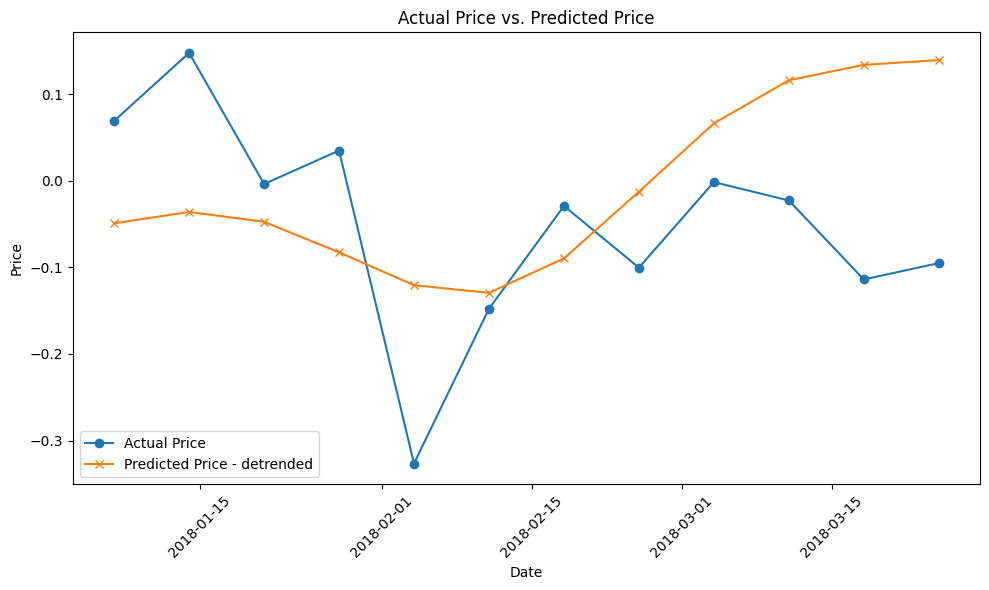

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(result_df_detrended['Date'], result_df_detrended['Detrended'], label='Actual Price', marker='o')
plt.plot(result_df_detrended['Date'], result_df_detrended['PredictPrice_detrended'], label='Predicted Price - detrended', marker='x')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Price vs. Predicted Price')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [40]:
mae = mean_absolute_error(result_df_detrended['Detrended'], result_df_detrended['PredictPrice_detrended'])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.12702635278578508


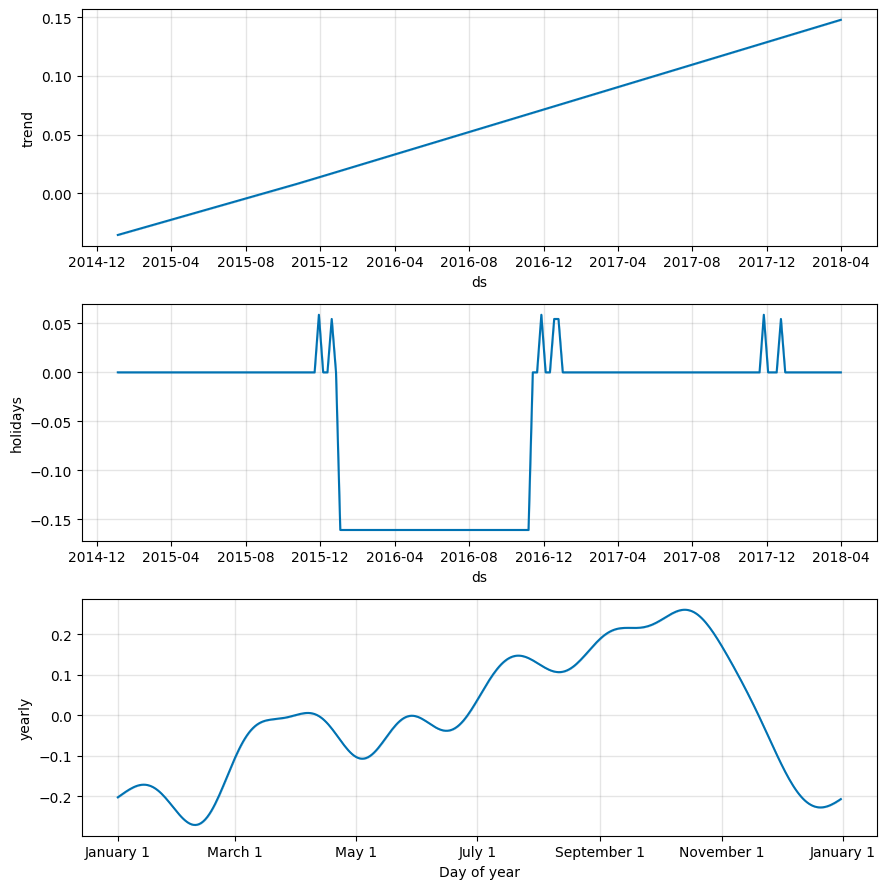

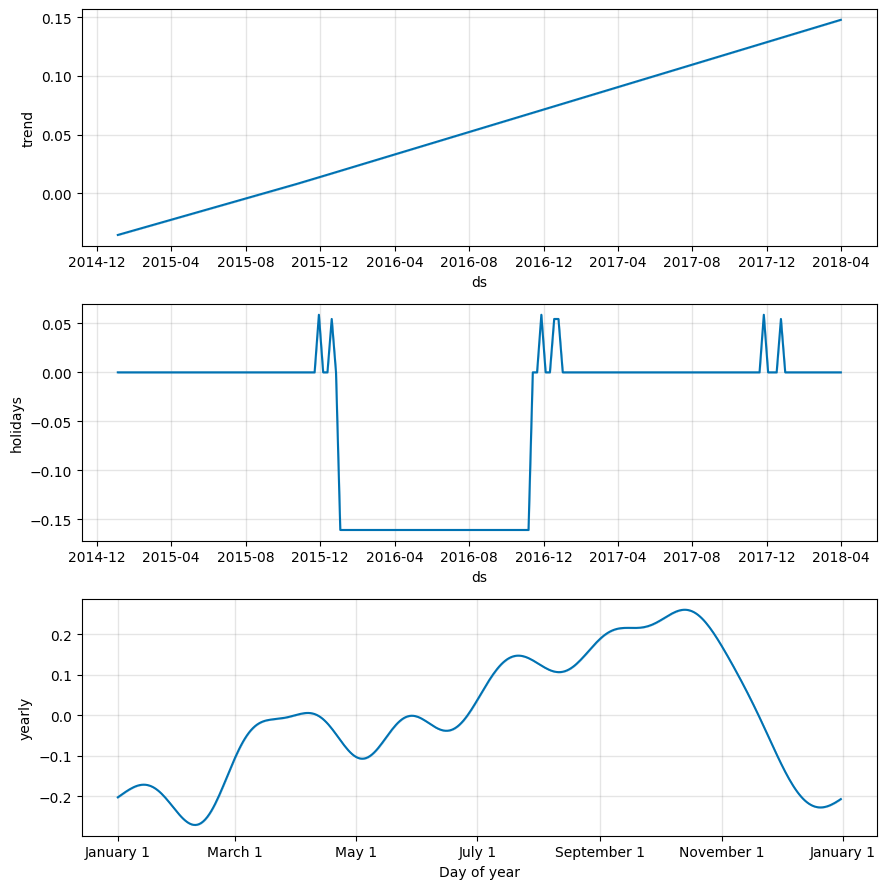

In [41]:
m.plot_components(forecast_detrended)

In [42]:
data_train_raw.columns=['ds', 'y']

In [43]:
model = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1, holidays=holidays)
model.fit(data_train_raw)

13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
future_raw = model.make_future_dataframe(periods=13, freq='W')
forecast_raw = model.predict(future_raw)
forecast_raw

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,BlackFriday_week,BlackFriday_week_lower,BlackFriday_week_upper,Election_prepare,...,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-04,1.012663,0.657223,0.984372,1.012663,1.012663,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.189201,-0.189201,-0.189201,0.0,0.0,0.0,0.823463
1,2015-01-11,1.012871,0.709008,1.040616,1.012871,1.012871,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.138275,-0.138275,-0.138275,0.0,0.0,0.0,0.874596
2,2015-01-18,1.013079,0.721794,1.043577,1.013079,1.013079,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.130911,-0.130911,-0.130911,0.0,0.0,0.0,0.882168
3,2015-01-25,1.013286,0.692611,1.003208,1.013286,1.013286,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.167709,-0.167709,-0.167709,0.0,0.0,0.0,0.845577
4,2015-02-01,1.013494,0.623030,0.967107,1.013494,1.013494,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.220344,-0.220344,-0.220344,0.0,0.0,0.0,0.793149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2018-03-04,1.366690,1.158831,1.490705,1.365638,1.367796,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.048614,-0.048614,-0.048614,0.0,0.0,0.0,1.318077
166,2018-03-11,1.369747,1.206152,1.541737,1.368480,1.371073,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.001186,-0.001186,-0.001186,0.0,0.0,0.0,1.368561
167,2018-03-18,1.372803,1.219366,1.574812,1.371328,1.374372,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017117,0.017117,0.017117,0.0,0.0,0.0,1.389920
168,2018-03-25,1.375859,1.234599,1.568789,1.374160,1.377638,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.023254,0.023254,0.023254,0.0,0.0,0.0,1.399113


In [45]:
forecast_raw_df = forecast_raw[['ds', 'yhat']]
forecast_raw_df.columns = ['Date', 'PredictPrice_raw']
forecast_raw_df

,Date,PredictPrice_raw
0,2015-01-04,0.823463
1,2015-01-11,0.874596
2,2015-01-18,0.882168
3,2015-01-25,0.845577
4,2015-02-01,0.793149
...,...,...
165,2018-03-04,1.318077
166,2018-03-11,1.368561
167,2018-03-18,1.389920
168,2018-03-25,1.399113


In [48]:
result_df_raw = pd.merge(data_predict_raw, forecast_raw_df, on='Date', how='left', validate='1:1')
result_df_raw = result_df_raw.sort_values(by='Date', ascending=True)
result_df_raw

,Date,AveragePrice,PredictPrice_raw
11,2018-01-07,1.19,1.180765
10,2018-01-14,1.27,1.216664
9,2018-01-21,1.12,1.204675
8,2018-01-28,1.16,1.158800
7,2018-02-04,0.80,1.115619
6,2018-02-11,0.98,1.111372
5,2018-02-18,1.10,1.158783
4,2018-02-25,1.03,1.239429
3,2018-03-04,1.13,1.318077
2,2018-03-11,1.11,1.368561


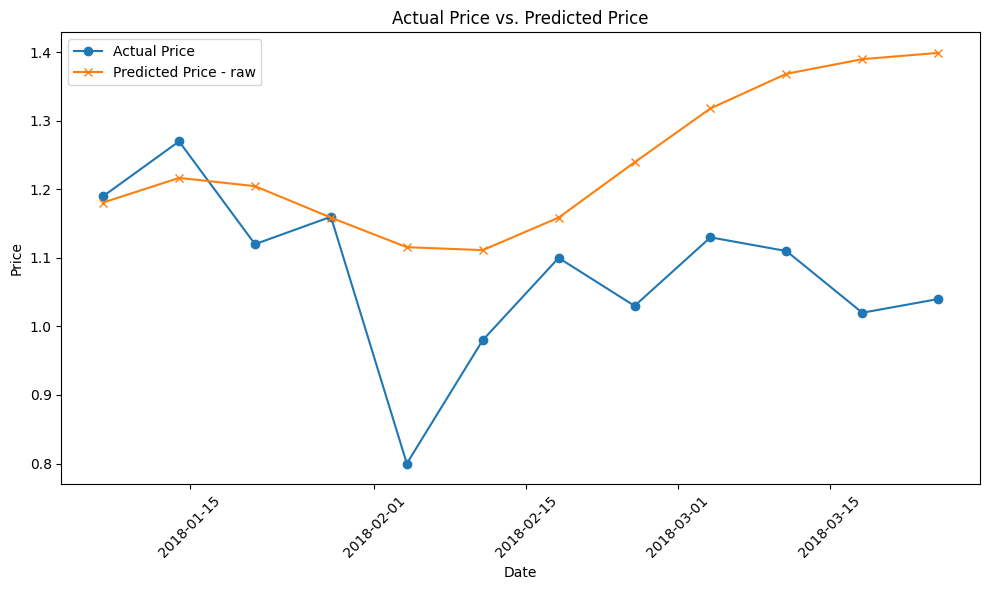

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(result_df_raw['Date'], result_df_raw['AveragePrice'], label='Actual Price', marker='o')
plt.plot(result_df_raw['Date'], result_df_raw['PredictPrice_raw'], label='Predicted Price - raw', marker='x')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual Price vs. Predicted Price')
plt.legend()
plt.grid(False)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
mae = mean_absolute_error(result_df_raw['AveragePrice'], result_df_raw['PredictPrice_raw'])
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.16994327428644876


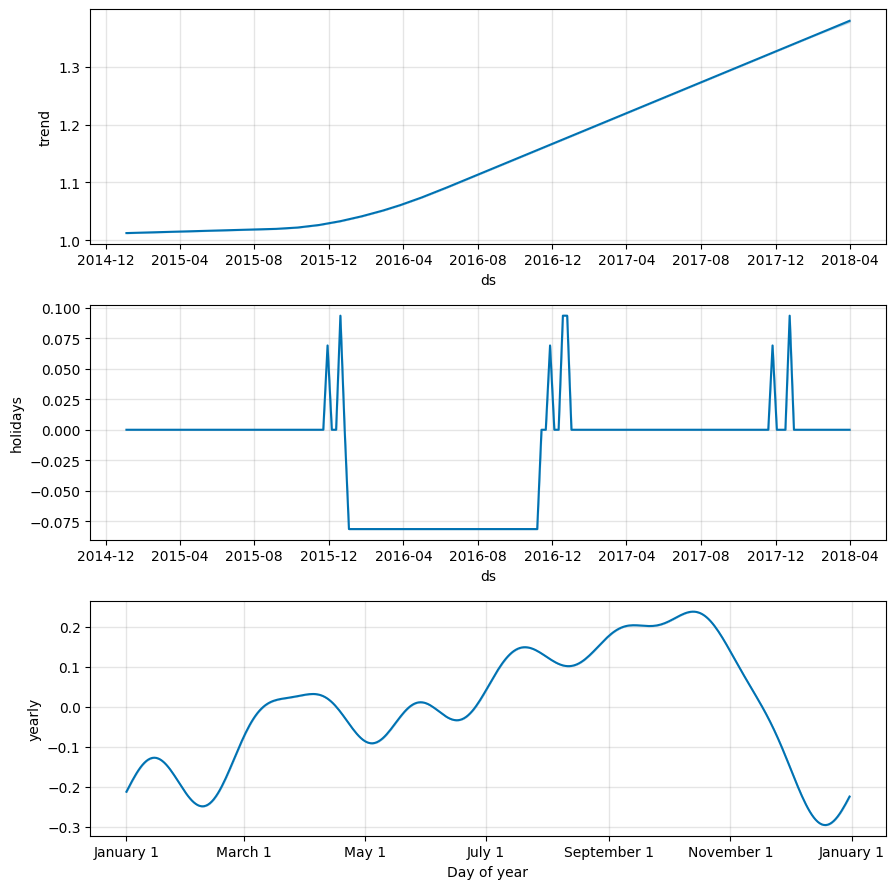

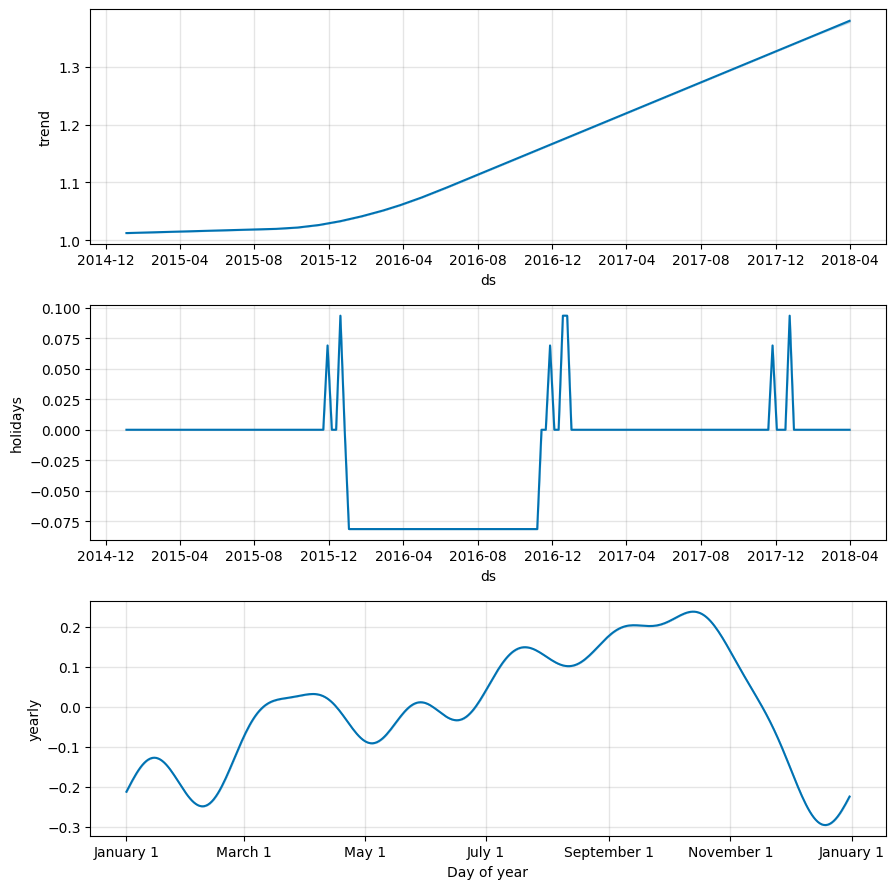

In [51]:
model.plot_components(forecast_raw)